In [25]:
# Import the drive module from google.colab
from google.colab import drive

# Mount your Google Drive to the Colab environment
drive.mount('/content/drive')

# Install the geopandas library for working with shapefiles and geospatial data
# The '!' runs a command line command
!pip install geopandas

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ward Data Head:
   OBJECTID ASS_CONST_  ASS_CONST1  WARD_NO                 WARD_NAME  \
0         1        150   Yelahanka      2.0          Chowdeswari Ward   
1         2        150   Yelahanka      3.0                    Atturu   
2         3        150   Yelahanka      4.0  Yelahanka Satellite Town   
3         4        151  K.R. Puram     51.0               Vijnanapura   
4         5        151  K.R. Puram     53.0              Basavanapura   

     POP_M    POP_F  POP_SC  POP_ST  POP_TOTAL  AREA_SQ_KM        LAT  \
0  10402.0   9224.0  2630.0   286.0    19626.0        7.06  13.121709   
1  13129.0  10891.0  2921.0   665.0    24020.0       10.15  13.102805   
2  13457.0  12325.0  3687.0   601.0    25782.0        4.90  13.090987   
3  18118.0  16969.0  6454.0   228.0    35087.0        2.05  13.006063   
4  11494.0  10518.0  4115.0   325.0    22012.0        6.28  13.016847   

         LON             RESERVATIO  \
0  77.580422                General   
1  77.560038        General 

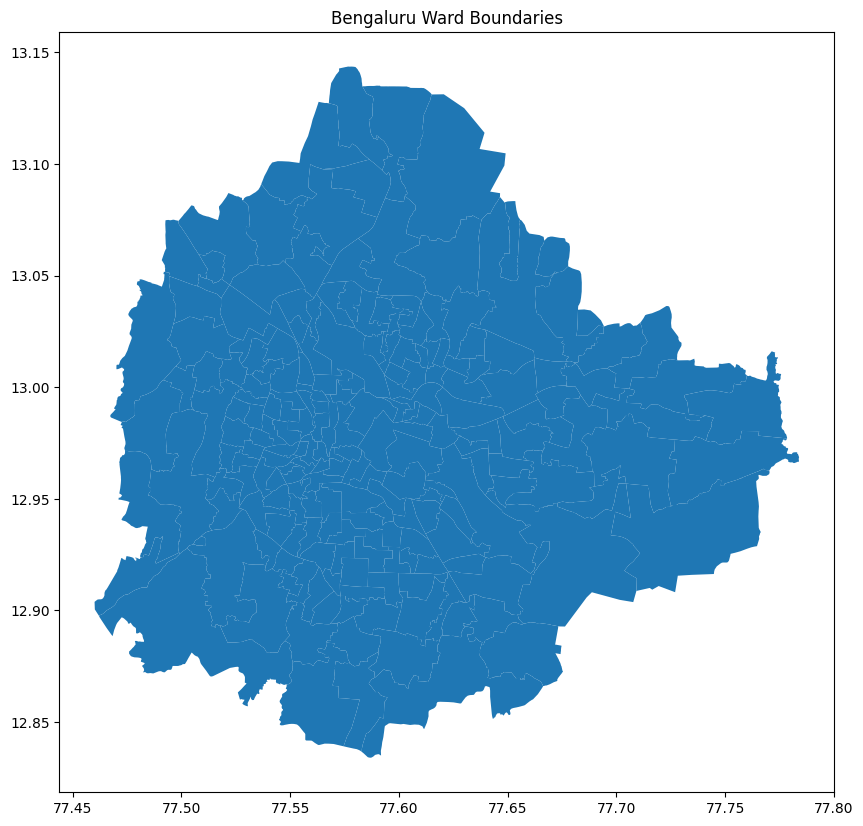

In [26]:
# Import the necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt

# Define the file path to your shapefile in Google Drive
ward_shapefile_path = '/content/drive/MyDrive/bbmpwards.shp'

# Read the shapefile into a GeoDataFrame
wards_gdf = gpd.read_file(ward_shapefile_path)

# Print the first 5 rows to see the data
print("Ward Data Head:")
print(wards_gdf.head())

# Create a simple plot to visually confirm it loaded correctly
wards_gdf.plot(figsize=(10, 10))
plt.title('Bengaluru Ward Boundaries')
plt.show()

In [27]:
import pandas as pd
import geopandas as gpd

# --- Load the raw, misaligned data ---
stops_filepath = '/content/drive/MyDrive/stops[1].txt' # Make sure this path is correct
stops_df_raw = pd.read_csv(stops_filepath)


# --- FIX THE COLUMN SHIFT ---
# Create a new, clean DataFrame by selecting the correct data and renaming the columns properly.
stops_df_clean = pd.DataFrame({
    'stop_lat': stops_df_raw['stop_id'],
    'stop_lon': stops_df_raw['stop_lat'],
    'stop_name': stops_df_raw['stop_lon']
})


# --- CLEAN DATA (same as before, but on the new DataFrame) ---
# Force the coordinate columns to be numeric.
stops_df_clean['stop_lat'] = pd.to_numeric(stops_df_clean['stop_lat'], errors='coerce')
stops_df_clean['stop_lon'] = pd.to_numeric(stops_df_clean['stop_lon'], errors='coerce')

# Drop any rows that have empty latitude or longitude values.
stops_df_clean.dropna(subset=['stop_lat', 'stop_lon'], inplace=True)


# --- Convert to GeoDataFrame ---
# Now use the fully cleaned and corrected DataFrame
stops_gdf = gpd.GeoDataFrame(
    stops_df_clean,
    geometry=gpd.points_from_xy(stops_df_clean.stop_lon, stops_df_clean.stop_lat),
    crs=wards_gdf.crs
)

print("\nBus Stop Data Head (after fixing and cleaning):")
print(stops_gdf.head())


Bus Stop Data Head (after fixing and cleaning):
      stop_lat   stop_lon         stop_name                   geometry
NaN  13.010290  77.583947     Palace Ground  POINT (77.58395 13.01029)
NaN  12.967957  77.591541   Pallavi Talkies  POINT (77.59154 12.96796)
NaN  13.116861  77.608376  Palanahalli Gate  POINT (77.60838 13.11686)
NaN  13.208726  77.501010       PALYA CROSS  POINT (77.50101 13.20873)
NaN  12.967793  77.590941   Pallavi Theatre  POINT (77.59094 12.96779)


Next, load the census data for Bengaluru wards. Make sure to update the file path below to the location of your census data CSV file and confirm that the CSV contains columns named `ward_name` and `population`.

In [37]:
import pandas as pd

census_filepath = '/content/drive/MyDrive/PCA_CDB_2918_F_Census.csv'
census_df = pd.read_csv(census_filepath, encoding='latin1', engine='python')

# PASTE THE CORRECT DISTRICT NAME YOU FOUND FROM THE LIST HERE
correct_district_name = 'Bengaluru Urban' # Replace this with the name from the list

# --- Data Cleaning with the correct district name ---
bengaluru_census_df = census_df[census_df['District_Name'] == correct_district_name].copy()

# The rest of the cleaning is the same
bengaluru_census_df = bengaluru_census_df[['Name', 'Total Population Person']]
bengaluru_census_df.rename(columns={'Name': 'ward_name', 'Total Population Person': 'population'}, inplace=True)

print("\nCleaned Census Data Head:")
print(bengaluru_census_df.head())


Cleaned Census Data Head:
Empty DataFrame
Columns: [ward_name, population]
Index: []


In [39]:
import pandas as pd

# Use your correct file path
census_filepath = '/content/drive/MyDrive/PCA_CDB_2918_F_Census.csv'

# Use the robust settings for reading the CSV
census_df = pd.read_csv(census_filepath, encoding='latin1', engine='python')

# --- Data Cleaning using 'Bangalore' as the district name ---
bengaluru_census_df = census_df[census_df['District_Name'] == 'Bangalore'].copy()

# Select and rename the correct columns
bengaluru_census_df = bengaluru_census_df[['Name', 'Total Population Person']]
bengaluru_census_df.rename(columns={'Name': 'ward_name', 'Total Population Person': 'population'}, inplace=True)

print("\nCleaned Census Data Head:")
print(bengaluru_census_df.head())


Cleaned Census Data Head:
         ward_name  population
0  Bangalore North      352420
1  Bangalore North      270195
2  Bangalore North       82225
3       Gopalapura        1026
4     Kukkanahalli         935


In [41]:
# --- 1. Perform the Spatial Join ---
stops_in_wards = gpd.sjoin(stops_gdf, wards_gdf, how="inner", predicate="within")

# --- 2. Count the Bus Stops in Each Ward ---
bus_stop_counts = stops_in_wards.groupby('WARD_NAME').size().reset_index(name='bus_stop_count')

# --- 3. Prepare for Merging by Cleaning Ward Names ---
wards_gdf['ward_name_clean'] = wards_gdf['WARD_NAME'].str.lower()
bus_stop_counts['ward_name_clean'] = bus_stop_counts['WARD_NAME'].str.lower()
bengaluru_census_df['ward_name_clean'] = bengaluru_census_df['ward_name'].str.lower()

# --- 4. Merge DataFrames Together ---
wards_with_stops = wards_gdf.merge(bus_stop_counts, on='ward_name_clean')
wards_analysis_gdf = wards_with_stops.merge(bengaluru_census_df, on='ward_name_clean')

print("--- Final Combined and Analysis-Ready Data ---")
print(wards_analysis_gdf[['WARD_NAME_x', 'bus_stop_count', 'population', 'geometry']].head())

--- Final Combined and Analysis-Ready Data ---
    WARD_NAME_x  bus_stop_count  population  \
0   Kodigehalli               9         152   
1   Mallasandra               3         830   
2   Mallasandra               3        1190   
3  Chokkasandra              10         432   
4  Gangenahalli               7         764   

                                            geometry  
0  POLYGON ((77.5871 13.06225, 77.5874 13.06089, ...  
1  POLYGON ((77.5188 13.0598, 77.51926 13.05949, ...  
2  POLYGON ((77.5188 13.0598, 77.51926 13.05949, ...  
3  POLYGON ((77.50731 13.04532, 77.50734 13.0453,...  
4  POLYGON ((77.59281 13.02391, 77.59277 13.02352...  


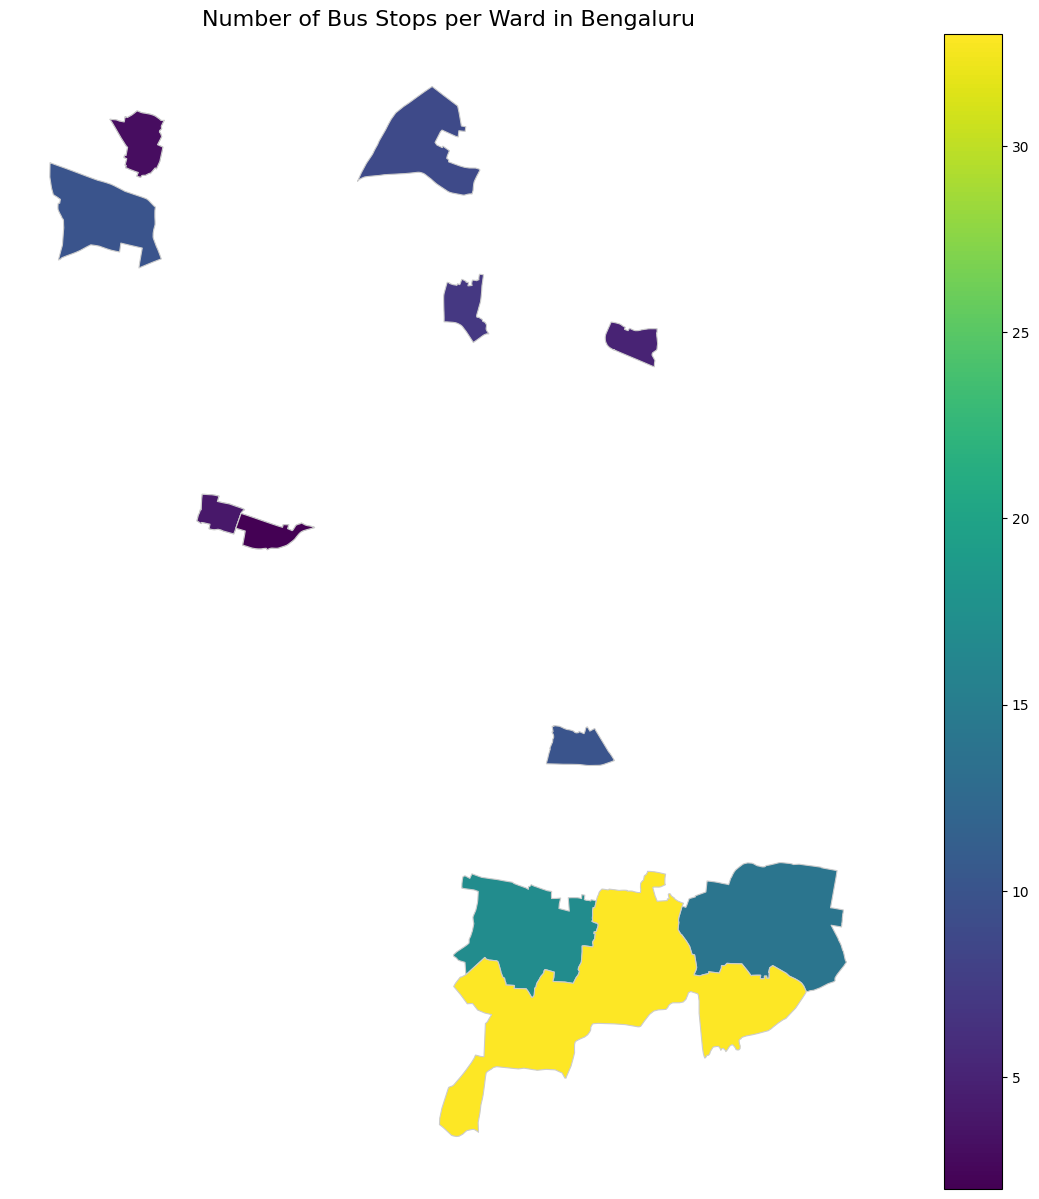

In [42]:
import matplotlib.pyplot as plt

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
wards_analysis_gdf.plot(column='bus_stop_count', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add a title and remove the axes for a cleaner look
ax.set_title('Number of Bus Stops per Ward in Bengaluru', fontdict={'fontsize': '16', 'fontweight': '3'})
ax.axis('off')

# Show the plot
plt.show()

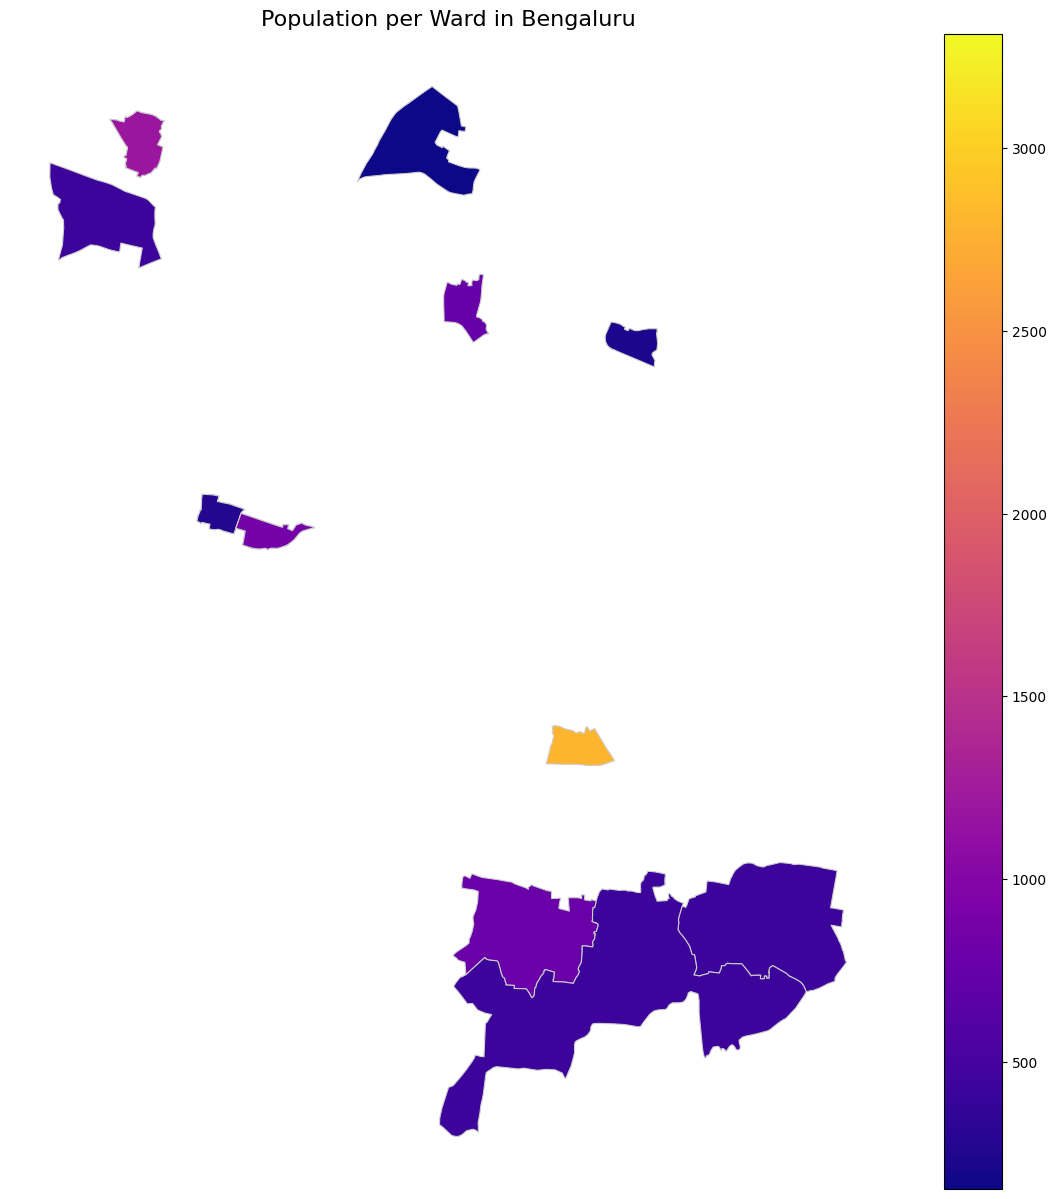

In [43]:
import matplotlib.pyplot as plt

# Create the choropleth map for population
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
wards_analysis_gdf.plot(column='population', cmap='plasma', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add a title
ax.set_title('Population per Ward in Bengaluru', fontdict={'fontsize': '16', 'fontweight': '3'})
ax.axis('off')

# Show the plot
plt.show()

In [44]:
# Calculate the number of bus stops per person in each ward
wards_analysis_gdf['population'] = wards_analysis_gdf['population'].astype(float)
wards_analysis_gdf['bus_stops_per_capita'] = (wards_analysis_gdf['bus_stop_count'] / wards_analysis_gdf['population']) * 1000

# Display the new column for the wards with the highest and lowest ratios
print("--- Wards with the BEST bus stop to population ratio ---")
print(wards_analysis_gdf.sort_values(by='bus_stops_per_capita', ascending=False).head())

print("\n--- Wards with the WORST bus stop to population ratio (Potential Deserts) ---")
print(wards_analysis_gdf.sort_values(by='bus_stops_per_capita', ascending=True).head())

--- Wards with the BEST bus stop to population ratio ---
    OBJECTID ASS_CONST_       ASS_CONST1  WARD_NO    WARD_NAME_x    POP_M  \
12       182        176  Bangalore South    192.0          Begur   9899.0   
0         16        152  Byatarayanapura      8.0    Kodigehalli  11525.0   
10       178        175    Bommana Halli    191.0    Singasandra  11669.0   
3         34        155      Dasarahalli     39.0   Chokkasandra  16821.0   
5         73        160   Sarvagna Nagar     49.0  Lingarajapura  16267.0   

      POP_F  POP_SC  POP_ST  POP_TOTAL  ...        LAT        LON  \
12   9388.0  3488.0   148.0    19287.0  ...  12.865000  77.622070   
0   10110.0  2724.0   372.0    21635.0  ...  13.053846  77.579088   
10   9741.0  2955.0   148.0    21410.0  ...  12.881166  77.657655   
3   13296.0  2571.0   383.0    30117.0  ...  13.038050  77.506307   
5   16108.0  5013.0   289.0    32375.0  ...  13.009946  77.626972   

               RESERVATIO                                        

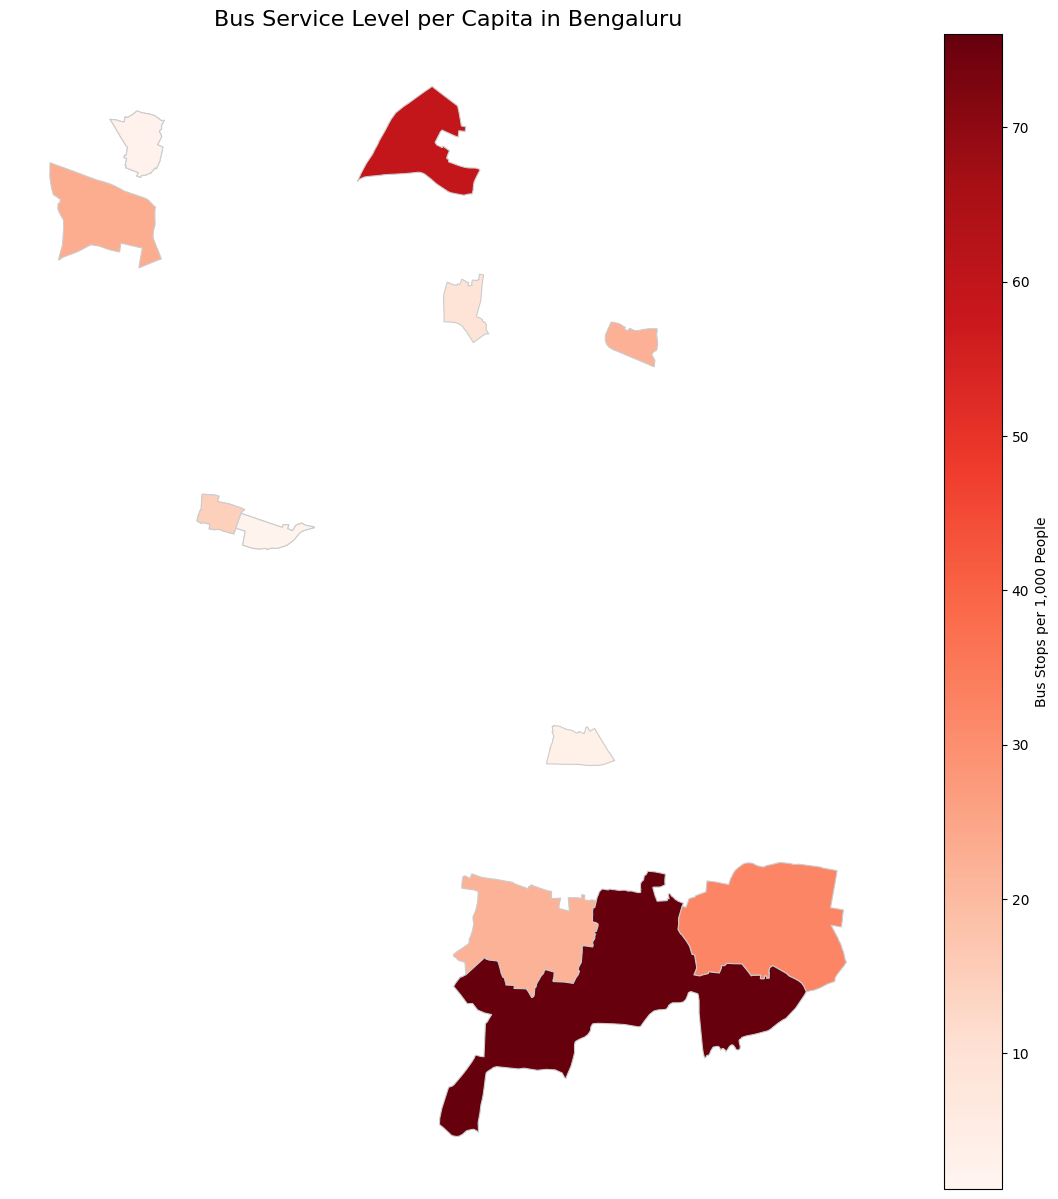

In [45]:
import matplotlib.pyplot as plt

# Create the final choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

wards_analysis_gdf.plot(
    column='bus_stops_per_capita',
    cmap='Reds',  # Using a 'Reds' colormap, where darker red means fewer stops per person
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Bus Stops per 1,000 People"} # Adds a label to the legend
)

# Add a title
ax.set_title('Bus Service Level per Capita in Bengaluru', fontdict={'fontsize': '16', 'fontweight': '3'})
ax.axis('off')

# Show the plot
plt.show()